# Assignment 2: Build a CNN for image recognition.

## Due Date:  March 27, 11:59PM

### Name: Manojkumar Venkatesan


## Introduction:

1. In this assignment, you will build Convolutional Neural Network to classify CIFAR-10 Images.
2. You can directly load dataset from many deep learning packages.
3. You can use any deep learning packages such as pytorch, keras or tensorflow for this assignment.

## Requirements:

1. You need to load cifar 10 data and split the entire training dataset into training and validation.
2. You will implement a CNN model to classify cifar 10 images with provided structure.
3. You need to plot the training and validation accuracy or loss obtained from above step.
4. Then you can use tuned parameters to train using the entire training dataset.
5. You should report the testing accuracy using the model with complete data.
6. You may try to change the structure (e.g, add BN layer or dropout layer,...) and analyze your findings.

## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

## Batch Normalization (BN)

### Background:

- Batch Normalization is a technique to speed up training and help make the model more stable.
- In simple words, batch normalization is just another network layer that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.

- For more detailed information, you may refer to the original paper: https://arxiv.org/pdf/1502.03167.pdf.

### BN Algorithm:

- Input: Values of $x$ over a mini-batch: $\mathbf{B}$ = $\{x_1,..., x_m\};$
- Output: $\{y_i = BN_{\gamma,\beta}(x_i)\}$, $\gamma, \beta$ are learnable parameters

Normalization of the Input:
$$\mu_{\mathbf{B}} = \frac{1}{m}\sum_{i=1}^m x_i$$
$$\sigma_{\mathbf{B}}^2 = \frac{1}{m}\sum_{i=1}^m (x_i - \mu_{\mathbf{B}})^2$$
$$\hat{x_i} = \frac{x_i - \mu_{\mathbf{B}}}{\sqrt{\sigma_{\mathbf{B}}}^2 + \epsilon}$$
Re-scaling and Offsetting:
$$y_i = \gamma \hat{x_i} + \beta = BN_{\gamma,\beta}(x_i)$$


### Advantages of BN:
1. Improves gradient flow through the network.
2. Allows use of saturating nonlinearities and higher learning rates.
3. Makes weights easier to initialize.
4. Act as a form of regularization and may reduce the need for dropout.

### Implementation:

- The batch normalization layer has already been implemented in many packages. You may simply call the function to build the layer. For example: torch.nn.BatchNorm2d() using pytroch package, keras.layers.BatchNormalization() using keras package.
- The location of BN layer: Please make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

## 1. Data preparation

### 1.1. Load data


In [1]:
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# Load Cifar-10 Data
# This is just an example, you may load dataset from other packages.
from sklearn.model_selection import train_test_split
from keras import datasets
import numpy as np

### If you can not load keras dataset, un-comment these two lines.
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

(train, trainlabels), (xtest, ytest) = datasets.cifar10.load_data()

print('shape of x_train: ' + str(train.shape))
print('shape of y_train: ' + str(trainlabels.shape))
print('shape of x_test: ' + str(xtest.shape))
print('shape of y_test: ' + str(ytest.shape))
print('number of classes: ' + str(np.max(trainlabels) - np.min(trainlabels) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels (5 points)

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Implement a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [3]:
def to_one_hot(y, num_class=10):
    return np.array(pd.get_dummies(y.reshape((y.shape[0])), dtype=float))

print("The original vector is")
print(trainlabels[0])
trainlabels = to_one_hot(trainlabels)
ytest = to_one_hot(ytest)

print('Shape of y_train_vec: ' + str(trainlabels.shape))
print('Shape of y_test_vec: ' + str(ytest.shape))


print(trainlabels[0])

The original vector is
[6]
Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets (5 points)

Randomly partition the 50K training samples to 2 sets: 
* a training set containing 40K samples: x_tr, y_tr
* a validation set containing 10K samples: x_val, y_val


In [4]:
xtrain, validation, ytrain, validation_label = train_test_split(train/255.0, trainlabels, test_size=0.2) 

print('Shape of x_tr: ' + str(xtrain.shape))
print('Shape of y_tr: ' + str(ytrain.shape))
print('Shape of x_val: ' + str(validation.shape))
print('Shape of y_val: ' + str(validation_label.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters (50 points)

- Build a convolutional neural network model using the below structure:

- It should have a structure of: Conv - ReLU - Max Pool - ConV - ReLU - Max Pool - Dense - ReLU - Dense - Softmax

- In the graph 3@32x32 means the dimension of input image, 32@30x30 means it has 32 filters and the dimension now becomes 30x30 after the convolution.
- All convolutional layers (Conv) should have stride = 1 and no padding.
- Max Pooling has a pool size of 2 by 2.




<img src="network.PNG"/>

- You may use the validation data to tune the hyper-parameters (e.g., learning rate, and optimization algorithm)
- Do NOT use test data for hyper-parameter tuning!!!
- Try to achieve a validation accuracy as high as possible.

In [5]:
# Build the model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
# model building
model = Sequential()

# conv layer 1
model.add(
    Conv2D(
        filters=32,
        kernel_size=3,
        strides=1,
        input_shape=(32,32,3),
        activation='relu'
    )
)
model.add(MaxPool2D(pool_size=2))
#model.add(BatchNormalization())
# conv layer 2
model.add(
    Conv2D(
        filters=64,
        kernel_size=4,
        strides=1,
        activation='relu'
    )
)
model.add(MaxPool2D(pool_size=2))
#model.add(BatchNormalization())

# Flatten
model.add(Flatten())
#model.add(Dropout(0.5))
# Dense 1
model.add(Dense(units=256, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))

# Dense 2
model.add(Dense(units=ytrain.shape[1], activation='softmax'))
model.summary()

2024-03-31 17:49:03.253056: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-03-31 17:49:03.253080: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-31 17:49:03.253096: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-31 17:49:03.253339: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-31 17:49:03.253617: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 256)               5

# IMPORTANT NOTES 

* The laptop used for this assignment was the new macbook, and tensorflow needs you to use the legacy optimisers if you want full access to the GPU. So thats why keras.legacy is used to import teh loss function. If you are not on a similar laptop (M1, M2, or M3 macbook) import `Adam` from `keras.optimizers` and not `keras.optimizers.legacy`
* The best way to make the process faster is to use a bigger batch size, which might provide poorer results but the training time is a lot faster 
* After testing, both batch size of 50 and 500 provided similar results 

In [6]:
# Define model optimizer and loss function
from keras.optimizers.legacy import Adam
learning_rate = 0.001
opt = Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
xtrain

array([[[[0.31372549, 0.29019608, 0.19607843],
         [0.3254902 , 0.30196078, 0.21176471],
         [0.37254902, 0.34901961, 0.25490196],
         ...,
         [0.42745098, 0.37254902, 0.2745098 ],
         [0.41960784, 0.37647059, 0.2745098 ],
         [0.40784314, 0.38039216, 0.2745098 ]],

        [[0.37647059, 0.34117647, 0.25098039],
         [0.36862745, 0.3372549 , 0.24705882],
         [0.37254902, 0.34509804, 0.25098039],
         ...,
         [0.54117647, 0.4745098 , 0.36862745],
         [0.5372549 , 0.4745098 , 0.36862745],
         [0.57647059, 0.51764706, 0.41176471]],

        [[0.38039216, 0.3372549 , 0.24705882],
         [0.36078431, 0.32156863, 0.22745098],
         [0.36078431, 0.32941176, 0.23137255],
         ...,
         [0.6627451 , 0.6       , 0.49803922],
         [0.69019608, 0.62352941, 0.51764706],
         [0.69803922, 0.62352941, 0.51372549]],

        ...,

        [[0.67058824, 0.6627451 , 0.63529412],
         [0.82745098, 0.82352941, 0.82352941]

In [8]:
validation

array([[[[0.63529412, 0.64705882, 0.71372549],
         [0.62745098, 0.63921569, 0.70588235],
         [0.62745098, 0.63921569, 0.70588235],
         ...,
         [0.61568627, 0.65098039, 0.72156863],
         [0.61176471, 0.65098039, 0.72156863],
         [0.61176471, 0.64705882, 0.71764706]],

        [[0.63529412, 0.65098039, 0.71764706],
         [0.62745098, 0.63921569, 0.70588235],
         [0.63137255, 0.64313725, 0.70980392],
         ...,
         [0.61176471, 0.66666667, 0.73333333],
         [0.61176471, 0.6627451 , 0.72941176],
         [0.61176471, 0.6627451 , 0.72941176]],

        [[0.61960784, 0.65490196, 0.71372549],
         [0.61176471, 0.64313725, 0.70588235],
         [0.61176471, 0.64705882, 0.70588235],
         ...,
         [0.61176471, 0.67058824, 0.74117647],
         [0.61176471, 0.67058824, 0.74117647],
         [0.61568627, 0.6745098 , 0.74509804]],

        ...,

        [[0.24313725, 0.27843137, 0.29803922],
         [0.23137255, 0.26666667, 0.29019608]

In [10]:
# Train the model and store model parameters/loss values
history = model.fit(
    xtrain, 
    ytrain,
    batch_size=500,
    epochs=10, 
    validation_data=(validation, validation_label),
)

Epoch 1/10
50/50 [==============================] - 6s 85ms/step - loss: 1.7220 - accuracy: 0.3771 - val_loss: 1.5650 - val_accuracy: 0.4275
Epoch 2/10
50/50 [==============================] - 3s 62ms/step - loss: 1.4672 - accuracy: 0.4745 - val_loss: 1.4164 - val_accuracy: 0.4923
Epoch 3/10
50/50 [==============================] - 3s 62ms/step - loss: 1.3481 - accuracy: 0.5228 - val_loss: 1.3252 - val_accuracy: 0.5309
Epoch 4/10
23/50 [============>.................] - ETA: 1s - loss: 1.2899 - accuracy: 0.5462

KeyboardInterrupt: 

## 3. Plot the training and validation loss curve versus epochs. (5 points)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


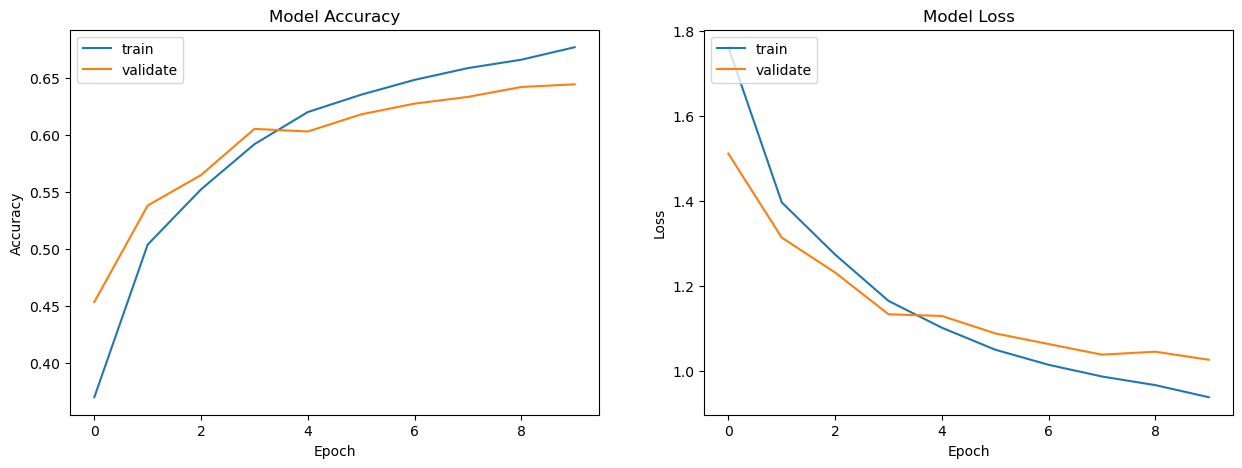

In [10]:
def plotmodelhistory(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())

plotmodelhistory(history)

# IMPORTANT hyper parameter comments

* The hyperparameters that were tuned were the model's optimizers, epochs and learning rate
* The optimizers that were tested were SGD, Adam and RMSprop. The best one was Adam, but RMSprop was very close 
* The learning rates that were tested were 0.001, 0.01, 0.05, 0.1. 0.05 was the best for RMSprop but the best for adam, the chosen learning rate was 0.001   

# My Notes

Clearly this accuracy and loss is objectively bad. It is better than an a random guess, which would have an accuracy of 10%. However this is not good enough. We will perform hyper parameter tuning with this model. Then add batchnorm layers and drop out layers which might give better results. What that might allow us to do is to run the model for more epochs without worrying about overfitting. Currently the model hasnt learnt much and might be overfitting as the difference between the validation loss and training loss is increasing  

## 4. Train (again) and evaluate the model (5 points)

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [11]:
#<Compile your model again (using the same hyper-parameters you tuned above)>
model = Sequential()

# conv layer 1
model.add(
    Conv2D(
        filters=32,
        kernel_size=3,
        strides=1,
        input_shape=(32,32,3),
        activation='relu'
    )
)
model.add(MaxPool2D(pool_size=2))
#model.add(BatchNormalization())
# conv layer 2
model.add(
    Conv2D(
        filters=64,
        kernel_size=4,
        strides=1,
        activation='relu'
    )
)
model.add(MaxPool2D(pool_size=2))
#model.add(BatchNormalization())

# Flatten
model.add(Flatten())
#model.add(Dropout(0.5))
# Dense 1
model.add(Dense(units=256, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))

# Dense 2
model.add(Dense(units=ytrain.shape[1], activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dense_2 (Dense)             (None, 256)              

In [12]:
#<Train your model on the entire training set (50K samples)>
# Define model optimizer and loss function
learning_rate = 0.001
opt = Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Train the model and store model parameters/loss values
history = model.fit(
    train/255.0,
    trainlabels,
    batch_size=500,
    epochs=10,
)

Epoch 1/10
100/100 [==============================] - 6s 47ms/step - loss: 1.6629 - accuracy: 0.4054
Epoch 2/10
100/100 [==============================] - 5s 46ms/step - loss: 1.2944 - accuracy: 0.5444
Epoch 3/10
100/100 [==============================] - 5s 48ms/step - loss: 1.1736 - accuracy: 0.5920
Epoch 4/10
100/100 [==============================] - 5s 46ms/step - loss: 1.0972 - accuracy: 0.6179
Epoch 5/10
100/100 [==============================] - 5s 46ms/step - loss: 1.0374 - accuracy: 0.6396
Epoch 6/10
100/100 [==============================] - 5s 46ms/step - loss: 0.9934 - accuracy: 0.6554
Epoch 7/10
100/100 [==============================] - 5s 46ms/step - loss: 0.9627 - accuracy: 0.6666
Epoch 8/10
100/100 [==============================] - 5s 45ms/step - loss: 0.9471 - accuracy: 0.6729
Epoch 9/10
100/100 [==============================] - 5s 46ms/step - loss: 0.9295 - accuracy: 0.6816
Epoch 10/10
100/100 [==============================] - 5s 46ms/step - loss: 0.9323 - accura

## 5. Evaluate the model on the test set (5 points)

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [14]:
# Evaluate your model performance (testing accuracy) on testing data.
score = model.evaluate(xtest/255.0, ytest, verbose=1)

313/313 [==============================] - 12s 38ms/step - loss: 0.9943 - accuracy: 0.6633


## 6. Building model with new structure (25 points)
- In this section, you can build your model with adding new layers (e.g, BN layer or dropout layer, ...)
- If you want to regularize a ```Conv/Dense layer```, you should place a ```Dropout layer``` before the ```Conv/Dense layer```.
- You can try to compare their loss curve and testing accuracy and analyze your findings.
- You need to try at lease two different structures.

# model 1: 

## structure 

* add a dropout layer before every dense layer (why? Because the dense layers are the main ones benifitting from  dropout. Conv layers dont benefit much from dropout becuase there are too few parameters (this is an assumption))
* Add a batch norm layer after every layer. That is, add batch norm in front of both conv and dense layers
* Using the same parameters and same network structure   

In [15]:
#<Compile your model again (using the same hyper-parameters you tuned above)>
model = Sequential()

# conv layer 1
model.add(
    Conv2D(
        filters=32,
        kernel_size=3,
        strides=1,
        input_shape=(32,32,3),
        activation='relu'
    )
)
model.add(MaxPool2D(pool_size=2))
model.add(BatchNormalization())
# conv layer 2
model.add(
    Conv2D(
        filters=64,
        kernel_size=4,
        strides=1,
        activation='relu'
    )
)
model.add(MaxPool2D(pool_size=2))
model.add(BatchNormalization())

# Flatten
model.add(Flatten())
# Dense 1
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())


# Dense 2
model.add(Dense(units=ytrain.shape[1], activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 15, 15, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                      

In [16]:
learning_rate = 0.001
opt = Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Train the model and store model parameters/loss values
history = model.fit(
    xtrain,
    ytrain,
    batch_size=500,
    epochs=30,
    validation_data=(validation, validation_label),
)

Epoch 1/30
80/80 [==============================] - 8s 70ms/step - loss: 1.6597 - accuracy: 0.4317 - val_loss: 2.4351 - val_accuracy: 0.1380
Epoch 2/30
80/80 [==============================] - 5s 61ms/step - loss: 1.2467 - accuracy: 0.5624 - val_loss: 3.4508 - val_accuracy: 0.0988
Epoch 3/30
80/80 [==============================] - 5s 61ms/step - loss: 1.0914 - accuracy: 0.6194 - val_loss: 4.2352 - val_accuracy: 0.1034
Epoch 4/30
80/80 [==============================] - 5s 62ms/step - loss: 0.9947 - accuracy: 0.6553 - val_loss: 4.1415 - val_accuracy: 0.1057
Epoch 5/30
80/80 [==============================] - 5s 62ms/step - loss: 0.9347 - accuracy: 0.6762 - val_loss: 3.7300 - val_accuracy: 0.1755
Epoch 6/30
80/80 [==============================] - 5s 61ms/step - loss: 0.8689 - accuracy: 0.7009 - val_loss: 2.5495 - val_accuracy: 0.2627
Epoch 7/30
80/80 [==============================] - 5s 62ms/step - loss: 0.8245 - accuracy: 0.7148 - val_loss: 1.9040 - val_accuracy: 0.3449
Epoch 8/30
80

In [18]:
score2 = model.evaluate(xtest/255.0, ytest)

313/313 [==============================] - 12s 37ms/step - loss: 1.0642 - accuracy: 0.6999


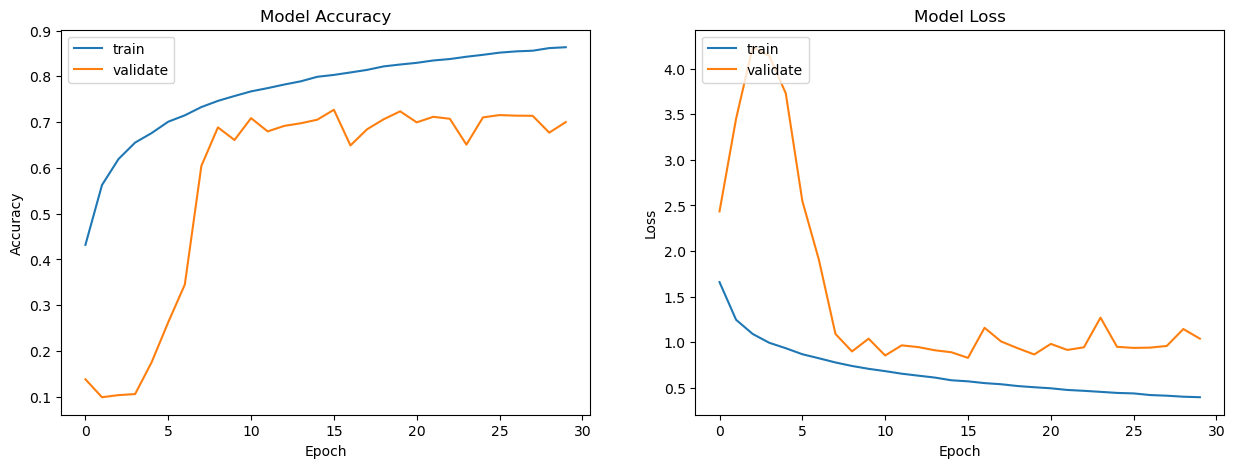

In [19]:
plotmodelhistory(history)

* Significant improvement compared to our base model 
* Test accuracy has also increased from 42 to 72. 

# Comments

* adding batch norm and dropout layer has helped significantly. 
* Lets test by adding a dropout layer for the conv layers too 

# model 2 

* add a dropout layer after every layer conv and dense alike. However the dropout of the conv layer's probability will be lesser
* Add a batch norm layer after every layer. That is, add batch norm in front of both conv and dense layers
* Using the same parameters and same network structure   

In [20]:
#<Compile your model again (using the same hyper-parameters you tuned above)>
model = Sequential()

# conv layer 1
model.add(
    Conv2D(
        filters=32,
        kernel_size=3,
        strides=1,
        input_shape=(32,32,3),
        activation='relu'
    )
)
model.add(MaxPool2D(pool_size=2))
model.add(Dropout(0.3))
model.add(BatchNormalization())
# conv layer 2
model.add(
    Conv2D(
        filters=64,
        kernel_size=4,
        strides=1,
        activation='relu'
    )
)
model.add(MaxPool2D(pool_size=2))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Flatten
model.add(Flatten())
# Dense 1
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())


# Dense 2
model.add(Dense(units=ytrain.shape[1], activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 batch_normalization_3 (Bat  (None, 15, 15, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 6, 6, 64)         

In [21]:
learning_rate = 0.001
opt = Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# Train the model and store model parameters/loss values
history = model.fit(
    xtrain,
    ytrain,
    batch_size=500,
    epochs=30,
    validation_data=(validation, validation_label),
)

Epoch 1/30
80/80 [==============================] - 8s 69ms/step - loss: 1.8878 - accuracy: 0.3571 - val_loss: 3.0803 - val_accuracy: 0.1205
Epoch 2/30
80/80 [==============================] - 5s 57ms/step - loss: 1.4659 - accuracy: 0.4785 - val_loss: 5.3881 - val_accuracy: 0.1019
Epoch 3/30
80/80 [==============================] - 5s 59ms/step - loss: 1.3072 - accuracy: 0.5329 - val_loss: 6.3122 - val_accuracy: 0.1019
Epoch 4/30
80/80 [==============================] - 5s 63ms/step - loss: 1.1975 - accuracy: 0.5770 - val_loss: 5.9329 - val_accuracy: 0.1019
Epoch 5/30
80/80 [==============================] - 5s 62ms/step - loss: 1.1219 - accuracy: 0.6082 - val_loss: 5.0310 - val_accuracy: 0.1019
Epoch 6/30
80/80 [==============================] - 5s 63ms/step - loss: 1.0631 - accuracy: 0.6303 - val_loss: 3.6977 - val_accuracy: 0.1327
Epoch 7/30
80/80 [==============================] - 5s 63ms/step - loss: 1.0187 - accuracy: 0.6440 - val_loss: 2.5719 - val_accuracy: 0.2508
Epoch 8/30
80

In [23]:
model.evaluate(xtest/255.0, ytest)

313/313 [==============================] - 13s 39ms/step - loss: 0.8506 - accuracy: 0.7063


[0.8506401181221008, 0.7063000202178955]

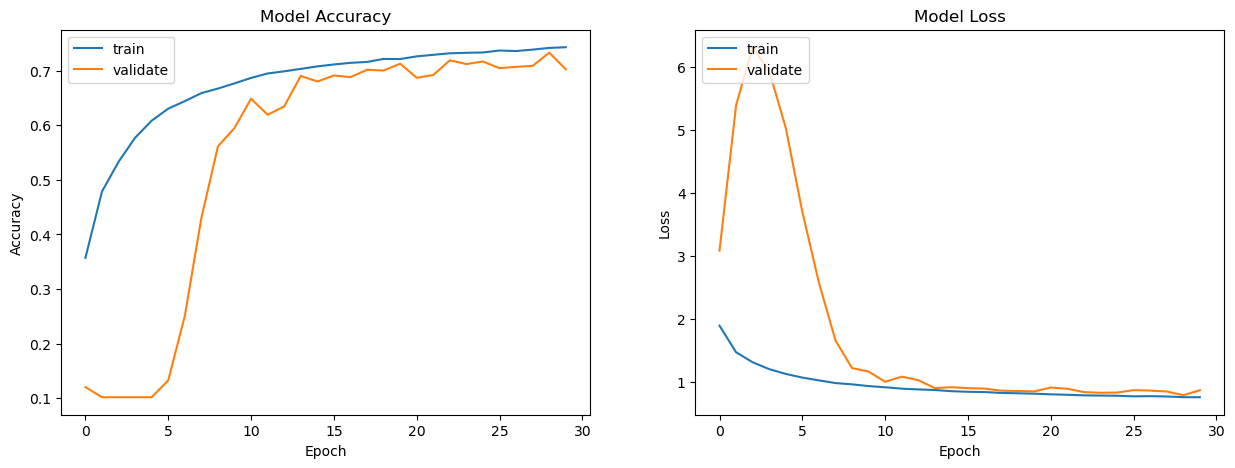

In [24]:
plotmodelhistory(history)

* This was considerably better. Maybe conv layers do need Dropout 
* However the accuracy has not increased by much 
* Howveer this has prevented overfitting which means more complex models will benefit from dropouts in the conv layer 

# Comemnts 

* I dont think the model is complex enough to understand teh dataset properly. 
* Attempt 3 will be to change the model structure, add more conv layers and maybe an extra dense Layer? 

# structure 

* Doubling the number of layers might help. 
* Conv2d -> Maxpool -> Conv2D -> Maxpool -> Conv2D -> Maxpool -> Conv2D -> Maxpool -> Flatten -> Dense -> Dense -> output

In [31]:
#<Compile your model again (using the same hyper-parameters you tuned above)>
model = Sequential()

# conv layer 1
model.add(
    Conv2D(
        filters=32,
        kernel_size=3,
        strides=1,
        input_shape=(32,32,3),
        activation='relu'
    )
)
model.add(Dropout(0.3))
model.add(MaxPool2D(pool_size=2))
model.add(BatchNormalization())
# conv layer 2
model.add(
    Conv2D(
        filters=32,
        kernel_size=3,
        strides=1,
        activation='relu'
    )
)
model.add(Dropout(0.3))
model.add(MaxPool2D(pool_size=2))
model.add(BatchNormalization())
# conv layer 3
model.add(
    Conv2D(
        filters=64,
        kernel_size=3,
        strides=1,
        activation='relu'
    )
)
model.add(Dropout(0.3))
model.add(BatchNormalization())
# Conv layer 4
model.add(
    Conv2D(
        filters=64,
        kernel_size=3,
        strides=1,
        activation='relu'
    )
)
model.add(Dropout(0.3))
model.add(MaxPool2D(pool_size=2))
model.add(BatchNormalization())
# Flatten
model.add(Flatten())
# Dense 1
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(units=100, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())


# Dense 2
model.add(Dense(units=ytrain.shape[1], activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 dropout_12 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_18 (Ba  (None, 15, 15, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_17 (Conv2D)          (None, 13, 13, 32)        9248      
                                                                 
 dropout_13 (Dropout)        (None, 13, 13, 32)       

In [32]:
learning_rate = 0.001
opt = Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
# Train the model and store model parameters/loss values
history = model.fit(
    xtrain,
    ytrain,
    batch_size=500,
    epochs=30,
    validation_data=(validation, validation_label),
)

Epoch 1/30
80/80 [==============================] - 13s 90ms/step - loss: 2.2461 - accuracy: 0.2296 - val_loss: 2.4059 - val_accuracy: 0.1031
Epoch 2/30
80/80 [==============================] - 5s 68ms/step - loss: 1.7810 - accuracy: 0.3417 - val_loss: 2.4516 - val_accuracy: 0.1108
Epoch 3/30
80/80 [==============================] - 5s 67ms/step - loss: 1.5856 - accuracy: 0.4148 - val_loss: 2.6189 - val_accuracy: 0.1037
Epoch 4/30
80/80 [==============================] - 5s 68ms/step - loss: 1.4664 - accuracy: 0.4652 - val_loss: 2.3130 - val_accuracy: 0.1402
Epoch 5/30
80/80 [==============================] - 5s 69ms/step - loss: 1.3750 - accuracy: 0.5015 - val_loss: 2.4135 - val_accuracy: 0.1490
Epoch 6/30
80/80 [==============================] - 5s 69ms/step - loss: 1.2973 - accuracy: 0.5339 - val_loss: 2.0025 - val_accuracy: 0.2662
Epoch 7/30
80/80 [==============================] - 5s 68ms/step - loss: 1.2445 - accuracy: 0.5597 - val_loss: 1.7344 - val_accuracy: 0.3606
Epoch 8/30
8

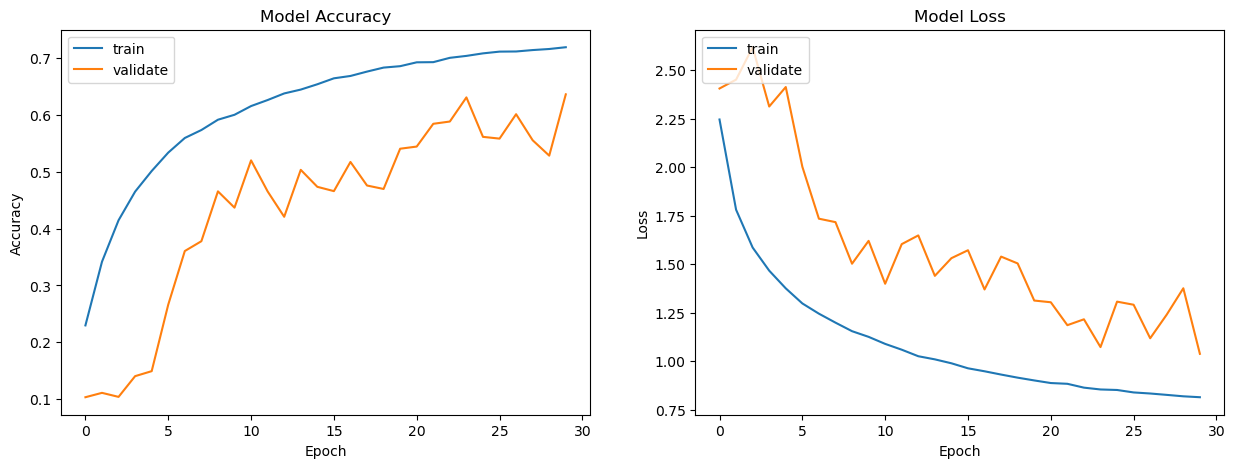

In [34]:
plotmodelhistory(history)

# comments 

* My initial asusmtion was wrong, the model is now overfitting 
* Maybe the best model is the second one after all
* 

# Student questions and queries

* In the final questions, the validation accuracy deosnt increase till the fifth epoch, why? 
* Do conv layers actually need dropout? 
* Is there a better model for this, will transfer learning work better? 
* is 70% the expected accuracy for this dataset? 